# UNSUPERVISED LEARNING

Compared to supervised learning where training data is labeled with the appropriate classifications, models using unsupervised learning must learn relationships between elements in a data set and classify the raw data without "help." This hunt for relationships can take many different algorithmic forms, but all models have the same goal of mimicking human logic by searching for indirect hidden structures, patterns or features to analyze new data.

<b>In short:</b>
* Unsupervised learning ﬁnds patterns in data e.g. clustering customers by their purchases
* Compressing the data using purchase patterns (dimension reduction)

## Import Packages

- `pandas` - for work with large data structures
- `numpy` - for mathematical,and numerical calculations
- `scikit-learn(sklearn)` - all important machine learning (and statistical) algorithms used for training the models
- `time` and `datetime` - datetime - ability to get current time for logs
- `math` - basic mathematical functions (as logarithm etc.))
- `scipy` - for metrics evaluation calculations
- `matplotlib` - for plotting the charts
- `seaborn` - for statistical visualisations

In [2]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans

import datetime
import time

import time
import scipy

import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

# Part 1: K-Means Clustering

## Dataset Overview : Mall Customer

You generally deploy k-means algorithms to subdivide data points of a dataset into clusters based on nearest mean values. To determine the optimal division of your data points into clusters, such that the distance between points in each cluster is minimized, you can use k-means clustering. In the term k-means, k denotes the number of clusters in the data.

There are 200 entires of the mall customer demographic data. Here is a quick overview of the dataset columns:

`CustomerID`: the customer ID indexed by the membership system

`Gender`: the gender of the mall customer

`Age`: the age of the mall member

`Annual Income (k$)`: the annual income of the customers with a unit of 1000 dollars

`Spending Score (1-100)`: the spending score from 1-100. 100 means the customer is a active shopper

## Load the dataset

In [3]:
data = pd.read_csv('mall_customers.csv',index_col='CustomerID')
print('Data loaded on', datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

Data loaded on 2021-09-02 23:52:42


## Data exploration

In [4]:
# Check dataset shape
print('Number of rows:',data.shape[0])
print('Number of columns:',data.shape[1])

Number of rows: 200
Number of columns: 4


In [5]:
data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


Dataset contains 5 columns CustomerID, Gender, Age, Annual Income (k$), Spending Score (1-100)

In [6]:
# initial check on dataset
## statistical summary?
## is there missing data?
## is there outlier data?

Showing the statistical summary, could help us on preliminary investigation on dataset

In [7]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Gender,200,2,Female,112,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,200.0,NaN,NaN,NaN,38.85,13.969007,18.0,28.75,36.0,49.0,70.0
Annual Income (k$),200.0,NaN,NaN,NaN,60.56,26.264721,15.0,41.5,61.5,78.0,137.0
Spending Score (1-100),200.0,NaN,NaN,NaN,50.2,25.823522,1.0,34.75,50.0,73.0,99.0


*Statistical summary metrics*

Categorical
- `count` - number of your rows/data point
- `unique` - number of unique values
- `top` - most appear values

Continuous
- `freq` - number of data point to the corresponding top values
- `mean`- mean/average
- `std` - standard deviation
- `min` - minimum value
- `25%` - Quartile-1(Q1)
- `50%` - Median
- `75%` - Quartile-3(Q3)
- `max` - maximum value

### Visualize the data

Showing also histogram to get more intuition about your data distribution

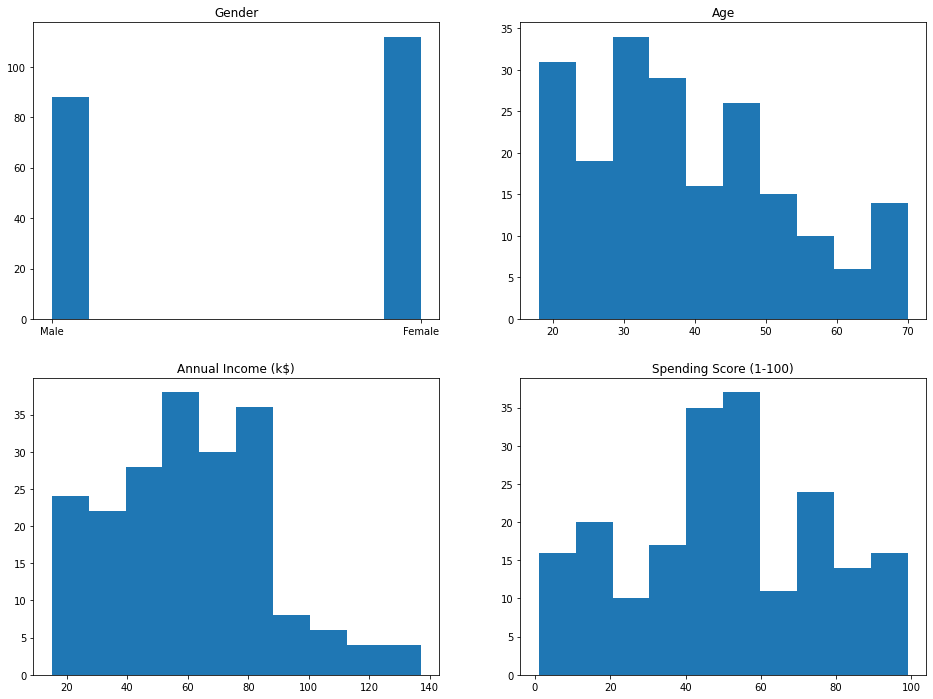

In [8]:
cols = list(data.columns)

plt.figure(figsize=(16,12))
for i,col in enumerate(cols, start = 1):
    plt.subplot(2,2,i)
    plt.hist(data[col])
    plt.title(col)
plt.show()

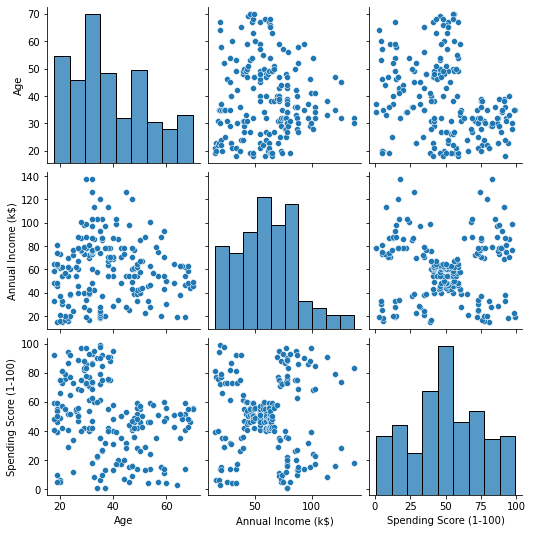

In [9]:
# Showing relationship between features
sns.pairplot(data[cols])
plt.show()

**Investigate columns with null values**

In [10]:
missingCol = data.isnull().sum()
print("There are", len(missingCol[missingCol != 0]),"columns with missing value")

There are 0 columns with missing value


**Outlier Detection with Inter Quartile method(IQR)**

In [11]:
## create functions
def outlier_thresholds(df, col):
    """ function to estimate non-outlier to outlier boundaries
    """
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    up_limit = q3 + 1.5 * iqr
    low_limit = q1 - 1.5 * iqr
    return low_limit, up_limit


def cnt_outliers(df, cols_pred, plot=False):
    """ function to estimate and plot number of outlier case
    """
    col_names = []
    for col in cols_pred:
        low_lim, up_lim = outlier_thresholds(df, col)
        if df[(df[col] > up_lim) | (df[col] < low_lim)].any(axis=None):
            number_of_outliers = df[(df[col] > up_lim) | (df[col] < low_lim)].shape[0]
            print(col, "'s outliers count:", number_of_outliers)
            col_names.append(col)
            if plot:
                sns.boxplot(x=df[col])
                plt.show()
    return col_names

Annual Income (k$) 's outliers count: 2


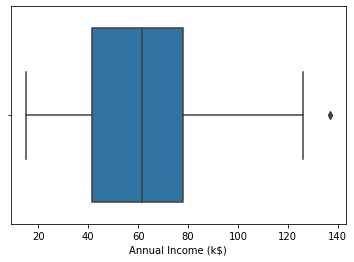

In [12]:
## create an instance to detect outlier
cols_num = data.select_dtypes(include='number')
a = cnt_outliers(data, cols_num, plot=True)

## Data Preprocessing

Since KMeans algorithm requires continuous data type, we then transform some data that have no fulfill the requirement

In [13]:
# Transform gender into 0 or 1 identifier
data['Gender'] = data['Gender'].apply(lambda x: 1 if x=='Male' else 0)

In [14]:
data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,1,19,15,39
2,1,21,15,81
3,0,20,16,6
4,0,23,16,77
5,0,31,17,40


## Model Fitting

Assume that we use `Annual Income` and `Spending Score` as reference to build the model. Usually, in unsupervised learning we don't have any reference variable then we need to find the best number of clusters based on the behavior of the data.

In [15]:
# Defining the model
model = KMeans(n_clusters=4,init='k-means++',random_state=42)

# Fitting the model
model.fit(data.loc[:,:'Spending Score (1-100)'])

KMeans(n_clusters=2, random_state=42)

<b>Parameters:</b>

`n_clusters`: int, optional, default: 8. <br>
The number of clusters

`init`: {‘k-means++’, ‘random’ or an ndarray}.  <br>
Method for initialization, defaults to ‘k-means++’:

`n_init` : int, default: 10 <br>
Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.

`max_iter` : int, default: 300 <br>
Maximum number of iterations of the k-means algorithm for a single run.

`precompute_distances` : {‘auto’, True, False} <br>
Precompute distances (faster but takes more memory).

`random_state` : int, RandomState instance or None (default) <br>
Determines random number generation for centroid initialization. Use an int to make the randomness deterministic. See Glossary.

### Create prediction

In [16]:
# create new column to store the prediction
data['segment'] = model.predict(data.loc[:,:'Spending Score (1-100)'])

In [17]:
data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),segment
CustomerID,,,,,
1,1,19,15,39,0
2,1,21,15,81,1
3,0,20,16,6,0
4,0,23,16,77,1
5,0,31,17,40,0


### Visualize the data

If we the plot  `Annual Income` vs `Speding Score` data with the prediction we can clearly see the clustering

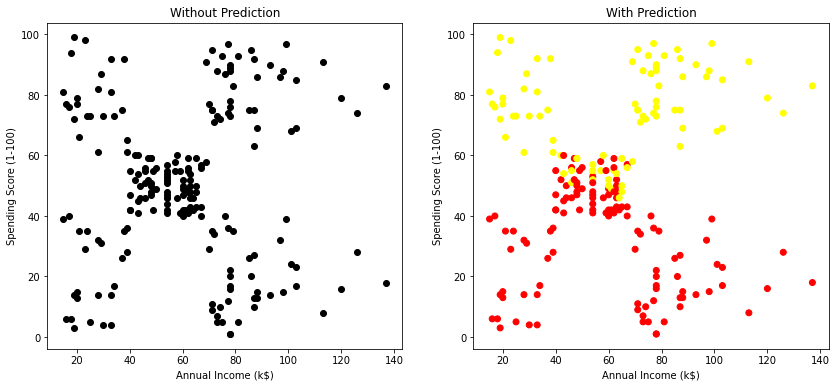

In [18]:
xs = data.loc[:,'Annual Income (k$)'] 
ys = data.loc[:,'Spending Score (1-100)'] 

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.scatter(xs, ys, c = 'black')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('Without Prediction')

plt.subplot(1,2,2)
plt.scatter(xs, ys, c=data['segment'], cmap='autumn')

plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('With Prediction')

plt.show()

### Try Different K

In [19]:
# Defining the model with n_clusters = 3
model2 = KMeans(n_clusters=3,init='k-means++',random_state=42)

# Fitting the model
model2.fit(data.loc[:,:'Spending Score (1-100)'])

KMeans(n_clusters=3, random_state=42)

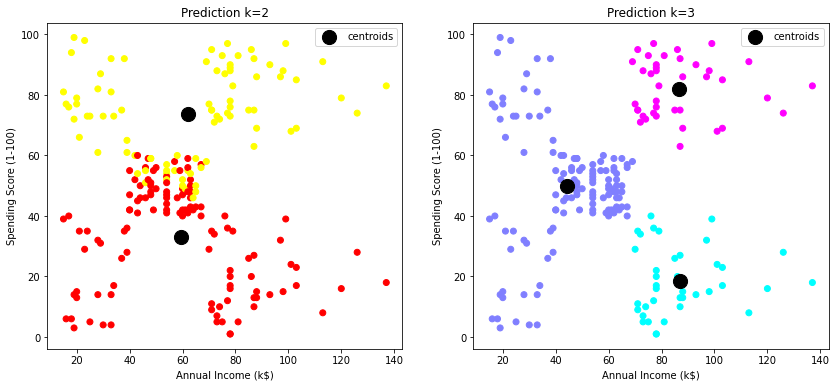

In [20]:
data['segment2'] = model2.predict(data.loc[:,:'Spending Score (1-100)'])
xs = data.loc[:,'Annual Income (k$)'] 
ys = data.loc[:,'Spending Score (1-100)'] 

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.scatter(xs, ys, c =data['segment'], cmap='autumn')
plt.scatter(model.cluster_centers_[:,2], model.cluster_centers_[:, 3], c='k', label='centroids' ,s=200)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.title('Prediction k=2')

plt.subplot(1,2,2)
plt.scatter(xs, ys, c=data['segment2'], cmap='cool')
plt.scatter(model2.cluster_centers_[:,2], model2.cluster_centers_[:, 3], c='k', label='centroids' ,s=200)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.title('Prediction k=3')

plt.show()

## Evaluating a Clustering

The question is which k is optimal? we can check the *inertia* or *Within-Cluster-Sum-of-Squared(WCSS)* distances of samples to their closest cluster center. The small inertia value shows better clustering.

<b>Inertia measures clustering quality:</b>
* Measures how spread out the clusters are (lower is better) 
* Distance from each sample to centroid of its cluster 
* After fit(), available as attribute inertia_ 
* k-means attempts to minimize the inertia when choosing clusters

In [21]:
print('wcss model 1:',model.inertia_)
print('wcss model 2:',model2.inertia_)

wcss model 1: 212889.44245524294
wcss model 2: 143391.59236035674


<b>The number of clusters (Experimenting different k):</b>
* Clusterings of the dataset with diﬀerent numbers of clusters 
* More clusters means lower inertia 
* What is the best number of clusters?

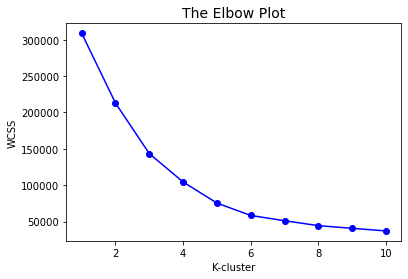

In [22]:
k_cluster = [1,2,3,4,5,6,7,8,9,10]
wcss = []

for K in k_cluster:
    kmean = KMeans(n_clusters=K)
    kmean.fit(data.loc[:,:'Spending Score (1-100)'])
    wcss.append(kmean.inertia_)

plt.plot(k_cluster, wcss, color='blue', marker='o')
plt.xlabel('K-cluster')
plt.ylabel('WCSS')
plt.title('The Elbow Plot', fontsize=14)
plt.show()

<b> Which is the best 'k'? </b>
* A good clustering has tight clusters (so low within-cluster-squared-sum) 
* ... but not too many clusters! 
* Choose an `"elbow"` in the plot, where wcss begins to decrease more slowly 

### Rebuild the model with selected K(=5)

In [23]:
# select k=5 as the best cluster
modelF = KMeans(n_clusters=5,init='k-means++',random_state=42)

# Fitting the model
modelF = modelF.fit(data.loc[:,:'Spending Score (1-100)'])

In [24]:
data['cluster'] = modelF.predict(data.loc[:,:'Spending Score (1-100)'])
data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),segment,segment2,cluster
CustomerID,,,,,,,
1,1,19,15,39,0,1,0
2,1,21,15,81,1,1,4
3,0,20,16,6,0,1,0
4,0,23,16,77,1,1,4
5,0,31,17,40,0,1,0


In [25]:
# count of eachs segment
data['cluster'].value_counts()

3    79
1    39
2    37
0    23
4    22
Name: cluster, dtype: int64

### Plot the final result

Text(0.5, 1.0, 'Mall Customer Final Segmentation')

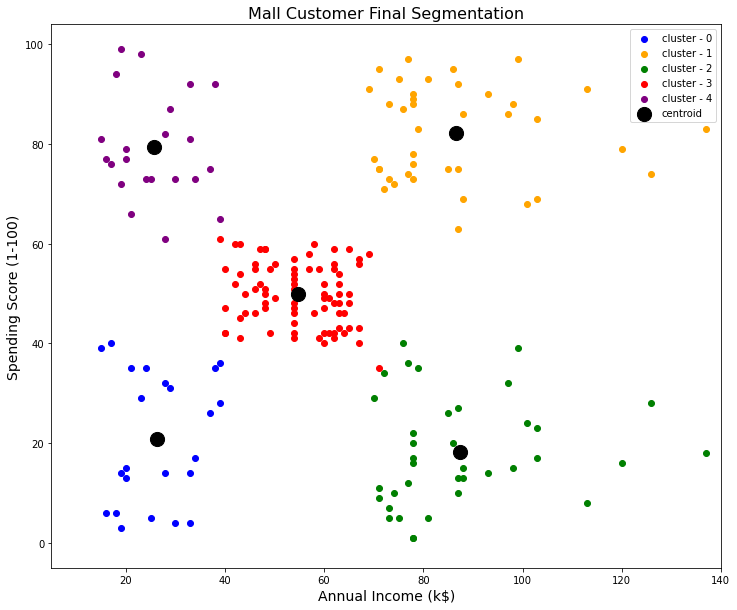

In [26]:
xs = data.loc[:,['Annual Income (k$)','cluster']]
ys = data.loc[:,['Spending Score (1-100)','cluster']]

plt.figure(figsize=(12,10))

#plot cluster
plt.scatter(xs[xs['cluster']==0], ys[ys['cluster']==0], c='b', label='cluster - 0')
plt.scatter(xs[xs['cluster']==1], ys[ys['cluster']==1], c='orange', label='cluster - 1')
plt.scatter(xs[xs['cluster']==2], ys[ys['cluster']==2], c='g', label='cluster - 2')
plt.scatter(xs[xs['cluster']==3], ys[ys['cluster']==3], c='r', label='cluster - 3')
plt.scatter(xs[xs['cluster']==4], ys[ys['cluster']==4], c='purple', label='cluster - 4')
#plot centroid
plt.scatter(modelF.cluster_centers_[:,2], modelF.cluster_centers_[:, 3], c='k',label='centroid' ,s=200)
              
plt.xlabel('Annual Income (k$)',fontsize=14)
plt.ylabel('Spending Score (1-100)',fontsize=14)
plt.xlim([5,140])
plt.legend()
plt.title('Mall Customer Final Segmentation',fontsize=16)

## Plot the final result

Text(0.5, 1.0, 'Mall Customer Final Segmentation')

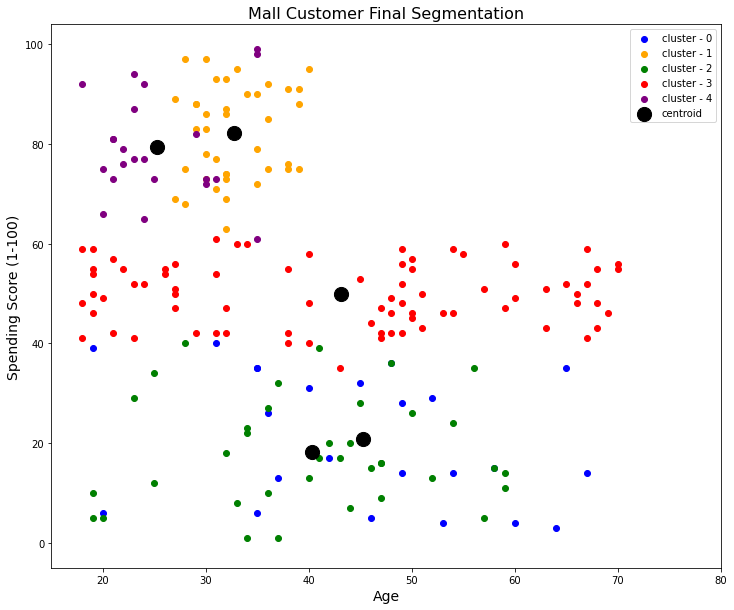

In [27]:
zs = data.loc[:,['Age','cluster']]
ys = data.loc[:,['Spending Score (1-100)','cluster']]

plt.figure(figsize=(12,10))

#plot cluster
plt.scatter(zs[zs['cluster']==0], ys[ys['cluster']==0], c='b', label='cluster - 0')
plt.scatter(zs[zs['cluster']==1], ys[ys['cluster']==1], c='orange', label='cluster - 1')
plt.scatter(zs[zs['cluster']==2], ys[ys['cluster']==2], c='g', label='cluster - 2')
plt.scatter(zs[zs['cluster']==3], ys[ys['cluster']==3], c='r', label='cluster - 3')
plt.scatter(zs[zs['cluster']==4], ys[ys['cluster']==4], c='purple', label='cluster - 4')

#plot centroid
plt.scatter(modelF.cluster_centers_[:,1], modelF.cluster_centers_[:, 3], c='k',label='centroid' ,s=200)

plt.xlabel('Age',fontsize=14)
plt.ylabel('Spending Score (1-100)',fontsize=14)
plt.xlim([15,80])
plt.legend()
plt.title('Mall Customer Final Segmentation',fontsize=16)

## result dataset

In [28]:
data.drop(['segment','segment2'],axis=1).head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
CustomerID,,,,,
1,1,19,15,39,0
2,1,21,15,81,4
3,0,20,16,6,0
4,0,23,16,77,4
5,0,31,17,40,0


## further analysis

Text(0.5, 1.0, 'Spending Score by cluster distribution')

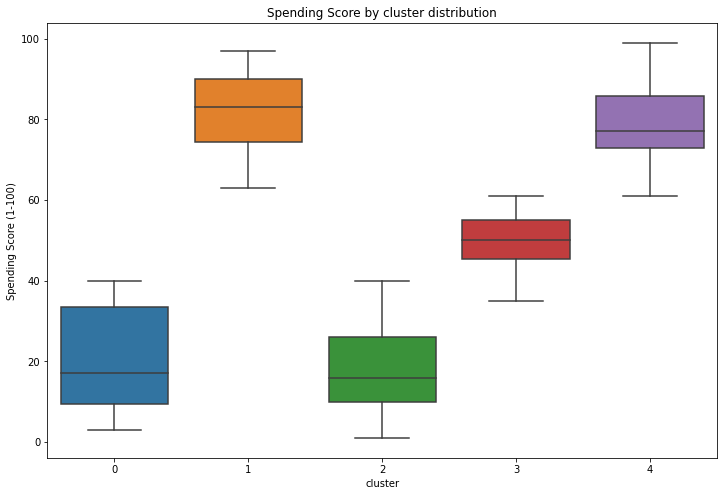

In [29]:
plt.figure(figsize=(12,8))
sns.boxplot(x="cluster",y="Spending Score (1-100)",data=data)
plt.title('Spending Score by cluster distribution')

Text(0.5, 1.0, 'Annual Income (k$) by cluster distribution')

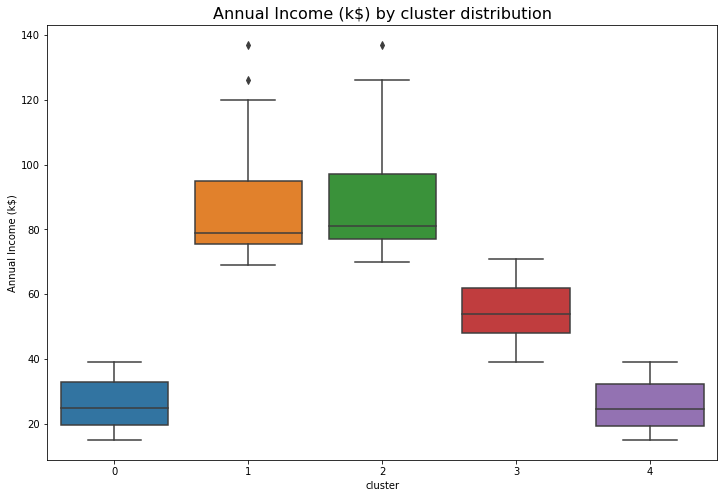

In [30]:
plt.figure(figsize=(12,8))
sns.boxplot(x="cluster",y="Annual Income (k$)",data=data)
plt.title('Annual Income (k$) by cluster distribution',fontsize=16)

Text(0.5, 1.0, 'Age by cluster distribution')

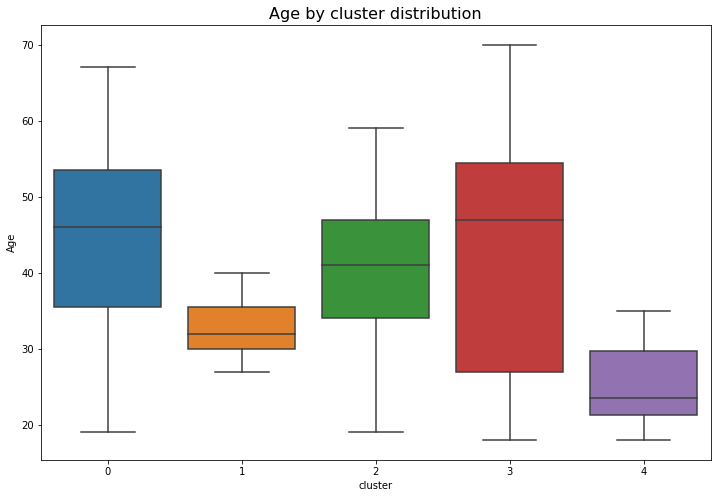

In [31]:
plt.figure(figsize=(12,8))
sns.boxplot(x="cluster",y="Age",data=data)
plt.title('Age by cluster distribution',fontsize=16)

## Interpretation on Clustering Result

From the above K-mean clustering model results with the optimal k selected using elbow method, we can observe 5 interesting clusters.

Analyzing the clusters, we can see the what each cluster represent:

`Cluster 0` having low income *(med:25k$)*, low spending score *(med:18)* in 35-55 range of age

`Cluster 1` having high income *(med:80k$)*, and high spending score *(med:82)* in 30-35 range age

`Cluster 2` having high income *(med:80k$)*, and low spending score *(med:18)* in 35-45 range of age

`Cluster 3` having medium income *(med:55k$)* and medium spending score *(med:55)* in all range of age (common customers)

`Cluster 4` having low income *(med:25k$)*, and high spending score *(med:78)* in 20-30 range of age

## Another Example: Iris Flower

In [32]:
iris = pd.read_csv(r'iris.csv')
iris.head(5)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Checking Iris flower species

In [33]:
iris['species'].value_counts()

versicolor    50
virginica     50
setosa        50
Name: species, dtype: int64

Assume we don't know the species of iris, we simply decide the k from the plot between `sepal_length` and `petal_width`

Text(0.5, 1.0, 'Iris_Flower')

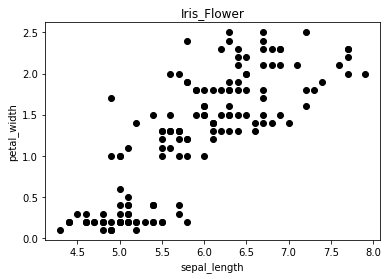

In [34]:
plt.scatter(iris['sepal_length'], iris['petal_width'], c=['black'])
plt.xlabel('sepal_length')
plt.ylabel('petal_width')
plt.title('Iris_Flower')

Text(0.5, 1.0, 'Clustering k=2')

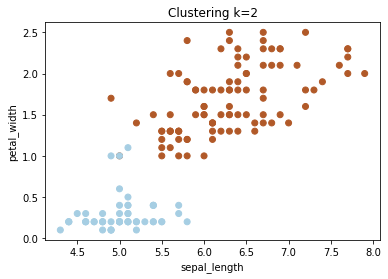

In [35]:
irisK = KMeans(n_clusters=2)
irisK.fit(iris.loc[:,:'petal_width'])
predict = irisK.predict(iris.loc[:,:'petal_width'])

plt.scatter(iris['sepal_length'], iris['petal_width'], c=predict, cmap='Paired')
plt.xlabel('sepal_length')
plt.ylabel('petal_width')
plt.title('Clustering k=2')

Finding the best clustering

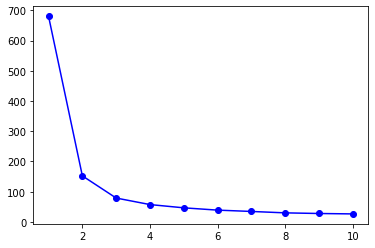

In [36]:
# setting up the possible K cluster
k = [1,2,3,4,5,6,7,8,9,10]
wcss = []

# create a looping
for K in k:
    kmean = KMeans(n_clusters=K)
    kmean.fit(iris.loc[:,:'petal_width'])
    wcss.append(kmean.inertia_)

plt.plot(k, wcss, color='blue', marker='o')
plt.show()

It looks like k = 3 will be a good choice

Text(0.5, 1.0, 'Clustering k=3')

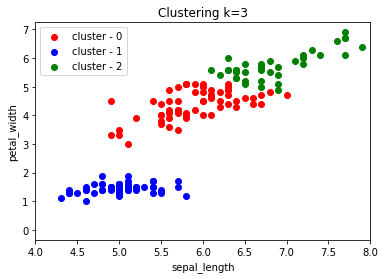

In [37]:
# create an instance for kmeans
irisK = KMeans(n_clusters=3)
#fitting the model with data
irisK.fit(iris.loc[:,:'petal_width'])
#create prediction from model
iris['segmentF'] = irisK.predict(iris.loc[:,:'petal_width'])

xs = iris.loc[:,['sepal_length','segmentF']]
ys = iris.loc[:,['petal_length','segmentF']]
#plot the cluster model result
plt.scatter(xs[xs['segmentF']==0], ys[ys['segmentF']==0], c='r', label='cluster - 0')
plt.scatter(xs[xs['segmentF']==1], ys[ys['segmentF']==1], c='b', label='cluster - 1')
plt.scatter(xs[xs['segmentF']==2], ys[ys['segmentF']==2], c='g', label='cluster - 2')
plt.xlabel('sepal_length')
plt.ylabel('petal_width')
plt.xlim([4,8])
plt.legend()
plt.title('Clustering k=3')

# Part 2: Hierarchical Clustering

Hierarchical clustering, also known as hierarchical cluster analysis, is an algorithm that groups similar objects into groups called clusters. The endpoint is a set of clusters, where each cluster is distinct from each other cluster, and the objects within each cluster are broadly similar to each other. Strategies for hierarchical clustering generally fall into two types:
* Agglomerative: This is a "bottom-up" approach: each observation starts in its own cluster, and pairs of clusters are merged as one moves up the hierarchy.
* Divisive: This is a "top-down" approach: all observations start in one cluster, and splits are performed recursively as one moves down the hierarchy.

## Dataset Overview: Eurovision2016

The Data contains scores from some countries to songs performed at the Eurovision 2016

## Load the dataset

In [38]:
euro = pd.read_csv(r'eurovision-2016.csv')
print('Data loaded on', datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

Data loaded on 2021-09-02 23:52:55


In [39]:
euro.head(5)

,From country,To country,Jury A,Jury B,Jury C,Jury D,Jury E,Jury Rank,Televote Rank,Jury Points,Televote Points
0,Albania,Belgium,20,16,24,22,24,25,14,NaN,NaN
1,Albania,Czech Republic,21,15,25,23,16,22,22,NaN,NaN
2,Albania,The Netherlands,22,14,23,24,21,24,24,NaN,NaN
3,Albania,Azerbaijan,19,12,11,21,11,13,19,NaN,NaN
4,Albania,Hungary,8,13,9,14,9,10,10,1.0,1.0


In [40]:
euro.shape

(1066, 11)

In [41]:
euro.describe().T

,count,mean,std,min,25%,50%,75%,max
Jury A,1066.0,13.195122,7.332698,1.0,7.0,13.0,20.0,26.0
Jury B,1066.0,13.195122,7.332698,1.0,7.0,13.0,20.0,26.0
Jury C,1066.0,13.195122,7.332698,1.0,7.0,13.0,20.0,26.0
Jury D,1066.0,13.195122,7.332698,1.0,7.0,13.0,20.0,26.0
Jury E,1066.0,13.195122,7.332698,1.0,7.0,13.0,20.0,26.0
Jury Rank,1066.0,13.195122,7.332698,1.0,7.0,13.0,20.0,26.0
Televote Rank,1066.0,13.195122,7.332698,1.0,7.0,13.0,20.0,26.0
Jury Points,420.0,5.800000,3.344643,1.0,3.0,5.5,8.0,12.0
Televote Points,420.0,5.800000,3.344643,1.0,3.0,5.5,8.0,12.0


### Agglomerative Hierarchical Clustering

* Every country begins as a cluster 
* At each step, the two closest clusters are merged 
* Continue until all countries in a single cluster 
* Height on dendrogram = distance between merging clusters

In [42]:
from scipy.cluster.hierarchy import linkage, dendrogram 
import numpy as np

hclust = euro.sample(frac=0.05)
score = hclust.loc[:,'Jury A':'Jury E'].values
country_names = hclust['From country'].values

## Fitting the cluster

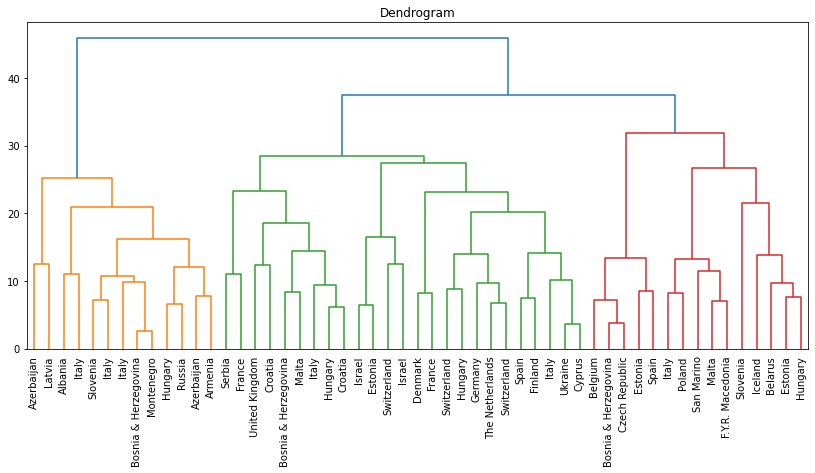

In [43]:
# create a hierarchical cluster
mergings = linkage(score, method='complete') 

plt.figure(figsize=(14,6))
dendrogram(mergings,labels=country_names,
            leaf_rotation=90,
            leaf_font_size=10) 

plt.title('Dendrogram')
plt.show()

### distance between clusters:
* Defined by a "linkage method" 
* Unsupervised Learning in Python
* Specified via method parameter, e.g. linkage(samples, method="complete") 
* **Different linkage method, different hierarchical clustering result!**

#### Option on Linkage method

* *'single'* --> Proximity between two clusters is the proximity between their two closest objects.
* *'complete'* --> Proximity between two clusters is the proximity between their two most distant objects. 
* *'average'* --> Proximity between two clusters is the proximity between their average distance of combined objects. 
* *'centroid'* --> Proximity between two clusters is the proximity between their geometric centroids

![Cat](images/linkage.png)

<b>Good Linkage Method</b> is usually based on interpretability. How meaningful are the results for you, the domain and, possibly audience/client

### simulate with every linkage method

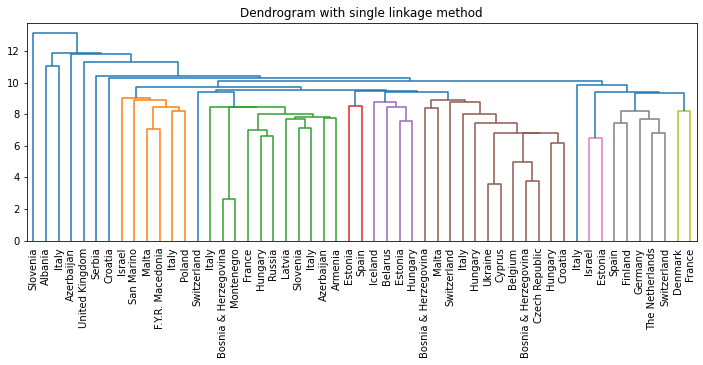

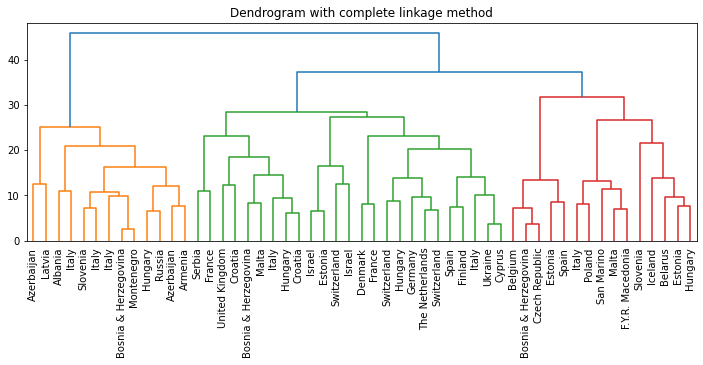

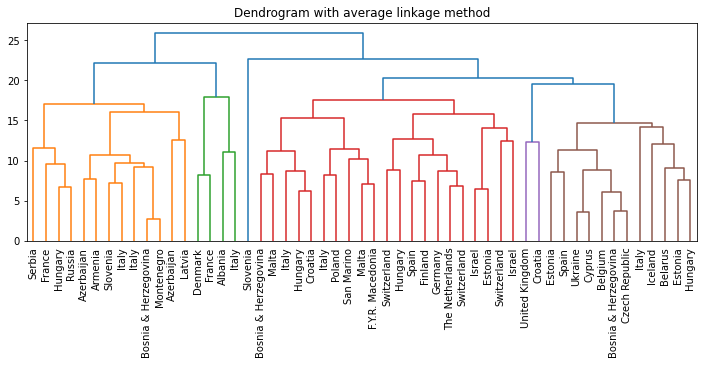

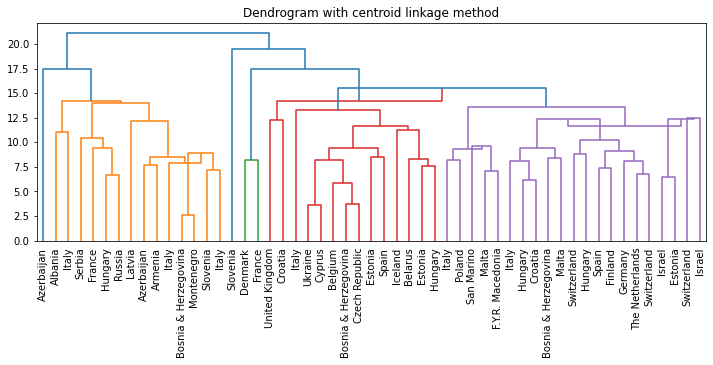

In [44]:
# define list of methods
methods = ['single','complete','average','centroid']

# simulate dendogram to methods
for i in methods:
    mergings = linkage(score, method=i) 

    plt.figure(figsize=(12,4))
    dendrogram(mergings,labels=country_names,
                leaf_rotation=90,
                leaf_font_size=10) 

    plt.title(f'Dendrogram with {i} linkage method')
    plt.show()

### Extracting Cluster Labels

For example, we want to extract label where the max distance is *20* and the linkage method is *complete*

Country list on cluster 1
['Azerbaijan' 'Latvia']

Country list on cluster 2
['Italy' 'Bosnia & Herzegovina' 'Slovenia' 'Azerbaijan' 'Albania'
 'Montenegro' 'Hungary' 'Russia' 'Armenia']

Country list on cluster 3
['Bosnia & Herzegovina' 'Hungary' 'United Kingdom' 'Serbia' 'France'
 'Croatia' 'Malta' 'Italy']

Country list on cluster 4
['Switzerland' 'Israel' 'Estonia']

Country list on cluster 5
['Denmark' 'Spain' 'France' 'Switzerland' 'Italy' 'The Netherlands'
 'Hungary' 'Germany' 'Finland' 'Ukraine' 'Cyprus']

Country list on cluster 6
['Estonia' 'Bosnia & Herzegovina' 'Czech Republic' 'Belgium' 'Spain']

Country list on cluster 7
['Italy' 'Malta' 'Poland' 'F.Y.R. Macedonia' 'San Marino']

Country list on cluster 8
['Estonia' 'Slovenia' 'Belarus' 'Iceland' 'Hungary']



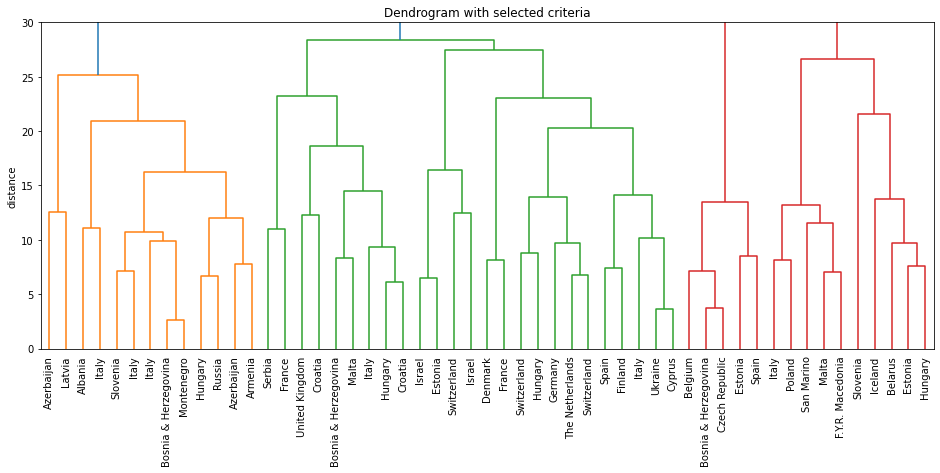

In [45]:
from scipy.cluster.hierarchy import fcluster 

#create the Cluster
mergings = linkage(score, method='complete') 
labels = fcluster(mergings, 25, criterion='distance') 

pairs = pd.DataFrame({'cluster': labels, 'countries': country_names}) 
for i in pairs['cluster'].sort_values().unique():
    print(f'Country list on cluster {i}')
    print(pairs[pairs['cluster']==i]['countries'].unique())
    print('')

#Plot the dendogram
plt.figure(figsize=(16,6))
dendrogram(mergings,labels=country_names,
            leaf_rotation=90,
            leaf_font_size=10) 

plt.title(f'Dendrogram with selected criteria')
plt.ylabel('distance')
plt.ylim([0,30])
plt.show()